# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os

# Suppress TensorFlow logging warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

def load_data(path, train=True):
    """
    Load data from a CSV file.

    Parameters
    ----------
    path: str
        The path to the CSV file.

    train: bool (default True)
        Specifies whether the data are training data.
        If True, random shuffling is applied.

    Returns
    -------
    X: numpy.ndarray
        The features as a multi-dimensional array of floats.
    labels/ids: numpy.ndarray
        The target labels for training data or IDs for test data.
    """
    df = pd.read_csv(path, encoding="ISO-8859-2")
    
    if train:
        # Shuffle training data to prevent ordering bias
        data = df.sample(frac=1, random_state=42).values
        X, labels = data[:, 1:-1].astype(np.float32), data[:, -1]
        return X, labels
    else:
        X, ids = df.iloc[:, 1:].values.astype(np.float32), df.iloc[:, 0].astype(str)
        return X, ids

def preprocess_data(X, scaler=None):
    """
    Preprocess input data by standardizing features to have zero mean and unit variance.
    
    Parameters
    ----------
    X: numpy.ndarray
        The input features to preprocess.
    
    scaler: StandardScaler, optional
        A pre-fitted scaler for transformation (used in testing).
    
    Returns
    -------
    X_scaled: numpy.ndarray
        The standardized features.
    scaler: StandardScaler
        The fitted scaler.
    """
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, scaler

def preprocess_labels(labels, encoder=None, categorical=True):
    """
    Encode labels as integers and optionally convert them to categorical one-hot encoding.
    
    Parameters
    ----------
    labels: numpy.ndarray
        The target labels to preprocess.
    
    encoder: LabelEncoder, optional
        A pre-fitted encoder for consistent label encoding.
    
    categorical: bool (default True)
        Whether to convert labels to one-hot encoding.
    
    Returns
    -------
    y: numpy.ndarray
        The encoded labels, either as integers or one-hot vectors.
    encoder: LabelEncoder
        The fitted label encoder.
    """
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = to_categorical(y)
    return y, encoder

# Load the dataset
url_train = './train.csv'
url_test = './test.csv'

# Load training data and labels
X_train, labels = load_data(url_train, train=True)

# Dimensionality inspection
print("Training set dimensions (rows, columns):", X_train.shape)
print("Number of features:", X_train.shape[1])

# Inspect the first few rows of the training set
print("\nFirst 5 samples of the training data:")
df_train = pd.read_csv(url_train)  # Load again for further inspection
print(pd.DataFrame(X_train).head())

# Inspecting labels
print("\nTraining set labels distribution:")
print(pd.Series(labels).value_counts())

# Check for missing values in the training data
print("\nMissing values in training data:")
print(df_train.isnull().sum())

# Additional EDA: Summary statistics for training data
print("\nSummary statistics for training data:")
print(df_train.describe())

# Inspecting test data dimensionality
X_test, ids = load_data(url_test, train=False)
print("\nTest set dimensions (rows, columns):", X_test.shape)

Training set dimensions (rows, columns): (25500, 23)
Number of features: 23

First 5 samples of the training data:
         0    1    2    3     4    5    6    7    8    9   ...       13  \
0   70000.0  2.0  3.0  2.0  26.0  0.0  0.0  0.0  0.0  0.0  ...   8948.0   
1  320000.0  2.0  2.0  2.0  28.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...    944.0   
2   30000.0  2.0  2.0  2.0  36.0  0.0 -1.0 -1.0  0.0  0.0  ...  30452.0   
3   20000.0  2.0  3.0  1.0  35.0  0.0  0.0  2.0  2.0  0.0  ...  18621.0   
4   80000.0  1.0  2.0  2.0  32.0  1.0  2.0  0.0  0.0  0.0  ...  28242.0   

        14       15       16      17       18      19      20      21      22  
0   9006.0  10570.0  11421.0  2000.0   1200.0  1500.0  2000.0  1000.0  2000.0  
1    473.0   1747.0   1193.0   390.0    944.0   473.0  5000.0  1200.0   980.0  
2  29667.0  28596.0  29180.0   490.0  33299.0  1400.0   572.0   584.0   400.0  
3  18024.0  18434.0  19826.0  3000.0   1000.0     0.0   700.0  1700.0     0.0  
4  21400.0      0.0      0.0     7

## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Funzioni necessarie
def load_data(url, train=True):
    df = pd.read_csv(url)
    print("Columns in the dataset:", df.columns.tolist())  # Stampa le colonne disponibili
    if train:
        # Utilizza il nome corretto per la colonna target
        if 'default payment next month' in df.columns:
            X = df.drop(columns=['default payment next month', 'ID'])  # Rimuovi la colonna target e l'ID
            y = df['default payment next month']
            return X, y
        else:
            raise KeyError("Column 'default payment next month' not found in the training dataset.")
    else:
        # Supponiamo che ci sia una colonna 'ID' da rimuovere
        if 'ID' in df.columns:
            X = df.drop(columns=['ID'])  # Rimuovi solo l'ID per il test
        else:
            X = df
        return X, df['ID']  # Modifica se hai un'altra colonna identificativa

def preprocess_data(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    return X_scaled, scaler

def preprocess_labels(y, encoder=None):
    if encoder is None:
        encoder = LabelEncoder()
        y_encoded = encoder.fit_transform(y)
        y_categorical = to_categorical(y_encoded)
    else:
        y_encoded = encoder.transform(y)
        y_categorical = to_categorical(y_encoded)
    return y_categorical, encoder

# Step 1: Load the data
url_train = './train.csv'
X_train_raw, labels_raw = load_data(url_train, train=True)

# Step 2: Handle missing values (if any)
df_train = pd.read_csv(url_train)

# Inspect if there are any missing values
print("Missing values in training data:")
print(df_train.isnull().sum())

# Optionally handle missing values (e.g., imputation)
# df_train.fillna(method='ffill', inplace=True)  # Un esempio di imputazione

# Step 3: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_raw, labels_raw, test_size=0.3, random_state=42, stratify=labels_raw)

# Step 4: Scale the features using StandardScaler
X_train_scaled, scaler = preprocess_data(X_train)
X_val_scaled, _ = preprocess_data(X_val, scaler)

# Step 5: Encode the labels
y_train_encoded, encoder = preprocess_labels(y_train)
y_val_encoded, _ = preprocess_labels(y_val, encoder)

# Step 6: Preprocessing test data
url_test = './test.csv'
X_test_raw, ids_test = load_data(url_test, train=False)
X_test_scaled, _ = preprocess_data(X_test_raw, scaler)

# Final datasets ready for model training
print("Training data (X_train_scaled):", X_train_scaled.shape)
print("Validation data (X_val_scaled):", X_val_scaled.shape)
print("Test data (X_test_scaled):", X_test_scaled.shape)

# You can also check the shapes of labels
print("Encoded training labels (y_train_encoded):", y_train_encoded.shape)
print("Encoded validation labels (y_val_encoded):", y_val_encoded.shape)

Columns in the dataset: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']
Missing values in training data:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3  

## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

In [73]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Assumiamo che X_train e y_train siano già definiti
# Normalizzare i dati di input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizza X_train
X_val_scaled = scaler.transform(X_val)  # Normalizza X_val con lo stesso scaler

# Controllo dei dati di input
check_data(X_train_scaled, y_train)

# Step 2: Definire l'architettura della rete neurale
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    model.add(Dense(256, activation='relu', kernel_regularizer='l2'))  # Layer con più neuroni
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Dropout ridotto a 0.4

    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(32, activation='leaky_relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))  # Layer di output

    # Compilare il modello
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Learning rate ridotto
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

# Step 3: Costruire il modello
input_shape = X_train_scaled.shape[1]  
model = build_model(input_shape)

# Step 4: Definire i parametri di addestramento
batch_size = 64
epochs = 300

# Step 5: Early stopping e learning rate scheduler per prevenire l'overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

model.summary()

# Step 6: Addestrare il modello
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=[early_stopping, reduce_lr])

# Step 7: Valutare il modello sul set di validazione
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Step 8: Calcolare e stampare l'F1 Score
y_pred_prob = model.predict(X_val_scaled)  
y_pred = (y_pred_prob > 0.5).astype(int)  

f1 = f1_score(y_val, y_pred)  
print(f"F1 Score: {f1}")

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_174 (Dense)               │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_123         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 50,369 (196.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5164 - loss: 4.0785 - val_accuracy: 0.5639 - val_loss: 3.6709 - learning_rate: 1.0000e-04
Epoch 2/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6547 - loss: 3.5287 - val_accuracy: 0.7894 - val_loss: 3.1754 - learning_rate: 1.0000e-04
Epoch 3/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7214 - loss: 3.0885 - val_accuracy: 0.8064 - val_loss: 2.7685 - learning_rate: 1.0000e-04
Epoch 4/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7585 - loss: 2.7061 - val_accuracy: 0.8095 - val_loss: 2.4186 - learning_rate: 1.0000e-04
Epoch 5/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7821 - loss: 2.3694 - val_accuracy: 0.8114 - val_loss: 2.1245 - learning_rate: 1.0000e-04
Epoch 6/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7941 - loss: 2.0874 - val_accuracy: 0.8122 - val_loss: 1.8779 - learning_rate: 1.0000e-04
Epoch 7/300
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

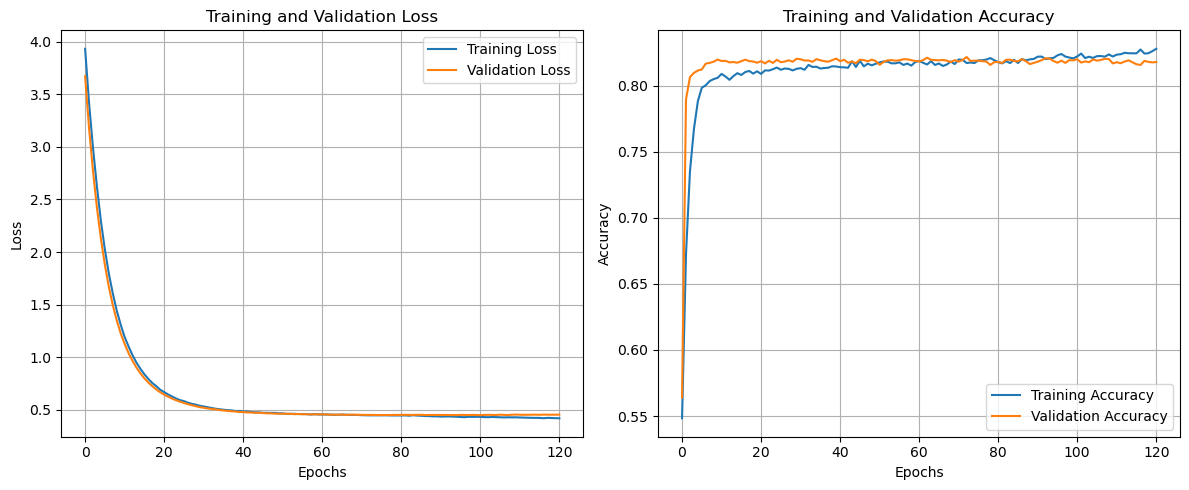

Final Training Loss: 0.4196
Final Validation Loss: 0.4538
Final Training Accuracy: 0.8278
Final Validation Accuracy: 0.8178
The model performs better on the training set compared to the validation set, which might indicate overfitting.


In [77]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy over epochs.

    Parameters
    ----------
    history: History
        Keras History object containing training metrics.
    """
    # Plotting Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Step 1: Call the plot function to visualize the training history
plot_training_history(history)

# Step 2: Analyze results
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Step 3: Initial considerations
if final_train_loss < final_val_loss:
    print("The model performs better on the training set compared to the validation set, which might indicate overfitting.")
elif final_train_loss > final_val_loss:
    print("The model performs better on the validation set compared to the training set, indicating potential underfitting.")
else:
    print("The model performs similarly on both sets, suggesting a good fit.")

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In [75]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Generate predictions on the validation set
y_val_pred_prob = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Confusion Matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(confusion)

# Step 3: Classification Report
class_report = classification_report(y_val, y_val_pred, target_names=["No Default", "Default"])
print("Classification Report:")
print(class_report)

# Step 4: Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[5600  345]
 [1033  672]]
Classification Report:
              precision    recall  f1-score   support

  No Default       0.84      0.94      0.89      5945
     Default       0.66      0.39      0.49      1705

    accuracy                           0.82      7650
   macro avg       0.75      0.67      0.69      7650
weighted avg       0.80      0.82      0.80      7650

ROC AUC Score: 0.7814


## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

In [81]:
# Load the test data
X_test, test_ids = load_data(url_test, train=False)

# Preprocess the test data
X_test_scaled, _ = preprocess_data(X_test)

# Step 1: Make predictions on the test set
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  # Threshold of 0.5 for binary classification

# Step 2: Create a DataFrame for submission or further analysis
results = pd.DataFrame({
    'Default_Prediction': y_test_pred.flatten()
})

# Step 3: Save predictions to a CSV file (optional)
results.to_csv('test_predictions.csv', index=False, header=False)

# Display predictions
print("Predictions on Test Set:")
print(results.head())


Columns in the dataset: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predictions on Test Set:
   Default_Prediction
0                   0
1                   0
2                   0
3                   0
4                   0


# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).